In [152]:
import os

import numpy as np
import pandas as pd
import pickle 
from tqdm import tqdm

from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

#keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Flatten, concatenate
from keras import Model
from keras.metrics import RootMeanSquaredError


# Plots
import matplotlib.pyplot as plt

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum
# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline

import logging
logging.raiseExceptions = False
import datetime

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

## Dataset general preparation

In [153]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df = df.set_index(["case", "t_point"])
df = df.sort_values(["case", "t_point"])
dynamic_idx = list(range(29, 42))
dynamic_columns = list(df.columns[dynamic_idx])
df.loc[:, dynamic_columns]
full_df = df.copy()
full_df

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                        

Exclude columns, which give information about how long the treatment was performed and about result

In [154]:
df = df.drop(["end_epizode", "admission_date", "current_process_duration", "process_stages", "outcome_tar", "long_observation_tar"], axis=1)

In [155]:
df.loc[df.index.levels[0][1]]

,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact,age_stat_fact,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control
t_point,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,1.21,20.7,55.0,22.0,7.8,8.1,0.201,24.1,0,1,189.0,17.7,73,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,2.09,21.0,72.0,18.0,8.8,7.0,0.204,33.2,0,5,NaN,19.8,73,0,0,0,0


Проверим, менялись ли процедуры или нет за время лечения пациентов. Если вектор не менялся, мы можем использовать статичный вектор при предсказании

In [156]:
t = df.groupby(level=0).nunique().iloc[:, 42:]
pd.DataFrame(t.value_counts())

0
age_stat_fact трансфузия_dinam_control оксигенотерапия_dinam_control НИВЛ_dinam_control ИВЛ_dinam_control      
1             1                        1                             1                  1                  1619
                                       2                             1                  1                   184
                                       1                             1                  2                    61
              2                        1                             1                  2                    34
                                                                                        1                    30
              1                        1                             2                  2                    12
              2                        1                             2                  2                    10
              1                        2                             1                  2                     9
                                       1                             2                  1                     8
              2                        2                             1                  1                     6
                                                                                        2                     6
                                       1                             2                  1                     5
              1                        2                             2                  1                     3
              2                        2                             2                  2                     3
              1                        2                             2                  2                     2

Процедуры менялись. Проверим, что лекарства не менялись во время лечения пациентов

In [157]:
t = df.groupby(level=0).nunique().iloc[:, :29]
pd.DataFrame(t.value_counts())

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0
омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1992


По лекарствам у всех пациентов набор препаратов не менялся, а по процедурам у 380 пациентов изменялся порядок.

Уберем всех пациентов лечившихся меньше 1 недели - они не дадут информации о развити заболевания


In [158]:
s = df.groupby(level=0).size()
df = df.loc[s[s>1].index.values]

Получили датасет для работы

In [159]:
df

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                        

Разберем отдельно параметры

### Лимфоциты
Исследуем зависимость параметров Лимфоциты# и Лимфоциты%. Проанализируем их

Text(0.5, 1.0, 'Зависимость распределения \n Лимфоциты% от Лимфоциты#')

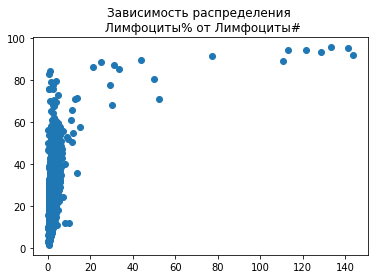

In [160]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
plt.scatter(data[:,0], data[:, 1])
plt.title("Зависимость распределения \n Лимфоциты% от Лимфоциты#")

Text(0.5, 1.0, 'Распределение величины Лимфоциты#_dinam_fact')

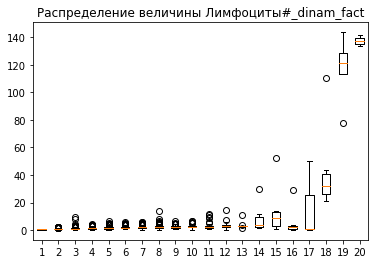

In [161]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты%_dinam_fact"]>i) & (df["Лимфоциты%_dinam_fact"]<i+5)]["Лимфоциты#_dinam_fact"] for i in range(0, 100, 5)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты#_dinam_fact")

Text(0.5, 1.0, 'Распределение величины Лимфоциты%_dinam_fact')

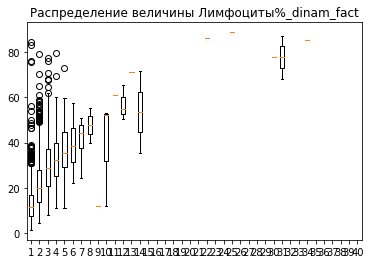

In [162]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты#_dinam_fact"]>i) & (df["Лимфоциты#_dinam_fact"]<i+1)]["Лимфоциты%_dinam_fact"] for i in range(0, 40, 1)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты%_dinam_fact")

Получается, что чистой корреляции у них нет. Однако чем выше количество лимфоцитов, тем больше их часть среди других лейкоцитов. Корреляцию Пирсона получаем 0.35 (P < 1e-159)

In [163]:
from scipy.stats import pearsonr
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = data[~np.isnan(data[:, 0]) & ~np.isnan(data[:, 1]) , :]
pearsonr(data[:, 0], data[:, 1])

PearsonRResult(statistic=0.35366027434981473, pvalue=5.609278436072053e-159)

Получили, что зависимость есть, но она не линейная, так что нужно оставить оба параметра

### Степень тяжести по КТ 


In [164]:
df["Cтепень тяжести по КТ_dinam_fact"].reset_index()["Cтепень тяжести по КТ_dinam_fact"].value_counts()

5    3242
2    1248
1     730
3     693
4     194
0      28
Name: Cтепень тяжести по КТ_dinam_fact, dtype: int64

Не особо понятно что такое 0 степень тяжести, такая степень 28 раз встречается. 5 - самая распространенная

Параметр является мультиклассовым, можно использовать как классификацию, так и регрессию, так как в какой то степени есть порядковый смысл между переменными

### Снижение сознания

In [165]:
df["снижение_сознания_dinam_fact"].reset_index()["снижение_сознания_dinam_fact"].value_counts()

0    5780
2     354
1       1
Name: снижение_сознания_dinam_fact, dtype: int64

Спокойно можно удалить 1, так как существует одна запись, и заменить 2 на 1. Также возможно использовать вероятности снижения сознания

## Распределения параметров

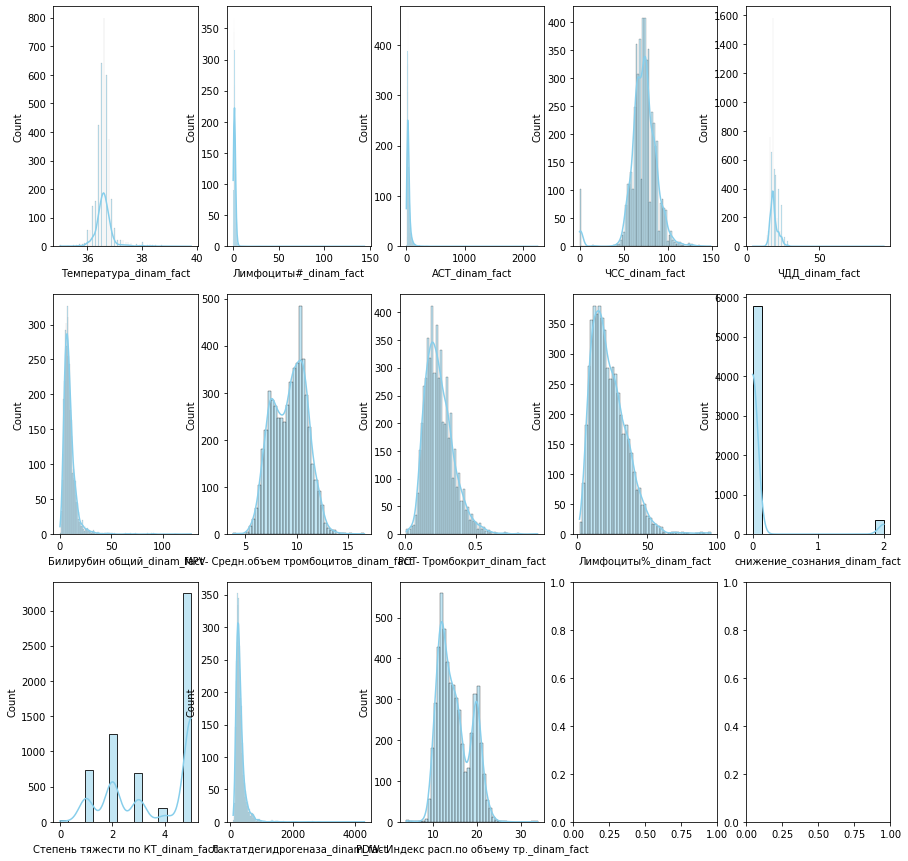

In [166]:
import seaborn as sns
figure, ax = plt.subplots(3, 5, figsize=(15, 15))
for i in range(13):
    sns.histplot(df.iloc[:, 29+i], color="skyblue", kde=True, ax=ax[i//5, i%5])

## Обучение

Теперь разделим датасет на окна - одна запись как фича, следующая за ней как таргет. И среди всех записей пациента проведем такую операцию

Выберем значения таргета без nan, и каждому из 13-ти параметров соотнесем пары - вектор параметров X и значение Y параметра на следующей неделе. 

In [167]:
def get_windows(df, window_size=2):
    X , y = [], []
    for i in df.index.levels[0]:
        try:
            for j in range(df.loc[i].index.size - window_size):
                try:
                    X.append(df.loc[(i, j):(i, j+window_size-1)])
                    y.append(df.loc[(i, j+window_size)].iloc[29:42])
                except:
                    pass
        except:
            pass
    X, y = np.array(X), np.array(y)
    data = {param: [] for param in dynamic_columns}

    for i in range(len(data)):
        X_temp, y_temp = [], []
        for j in range(y.shape[0]):
            if not np.isnan(y[j][i]):
                X_temp.append(X[j])
                y_temp.append(y[j][i])
        data[dynamic_columns[i]] = {"X": np.array(X_temp), "y": np.array(y_temp)}

    return data
data = get_windows(df, 2)

In [168]:
data['Лимфоциты#_dinam_fact']["X"][3]

array([[1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.660e+01,
        1.090e+00, 2.254e+02, 7.300e+01, 2.400e+01, 6.800e+00, 9.900e+00,
        5.400e-01, 5.600e+00, 0.000e+00, 3.000e+00, 6.750e+02, 1.090e+01,
        3.700e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.640e+01,
        2.450e+00, 2.400e+01,       nan, 1.800e+

In [20]:
data['Лимфоциты#_dinam_fact']["y"][0]

2.13

Теперь посмотрим, сколько пар для обучения у нас присутствует

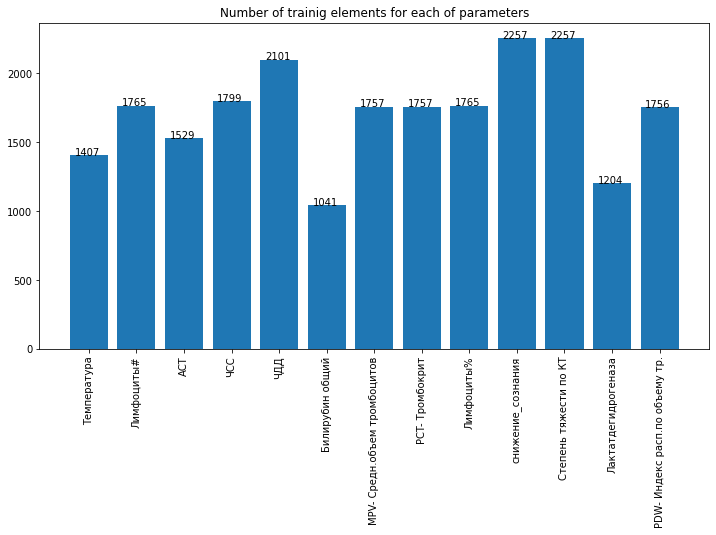

In [169]:
def get_samples_for_parameters(data):
  stat_nan = {k[:-11]:len(data[k]["X"]) for k in data}
  l = stat_nan.keys()
  h = stat_nan.values()
  plt.figure(figsize=(12, 6))
  plt.bar(x=l, height=h)
  plt.xticks(rotation=90)
  plt.title("Number of trainig elements for each of parameters")
  for key_idx, key in enumerate(stat_nan):
    plt.text(key_idx-0.3,stat_nan[key]+1,stat_nan[key])

get_samples_for_parameters(data)

Нам важно измерить качество регрессии. Будем вычислять R2, MSE, mAPE и 95% интервалы этих метрик. Для доверительных интервалов будем использовать значения метрик модели на 5 фолдах (иными словами кросс валидацию) https://www.codecamp.ru/blog/confidence-intervals-python/

In [23]:
import scipy.stats as st

# Calculate R2, MSE, MAPE
def get_scores(y_real, y_pred):
    scores = {}
    scores["r2"] = r2_score(y_real, y_pred, multioutput="raw_values")
    scores["mse"] = mean_squared_error(y_real, y_pred, multioutput="raw_values")
    scores["mape"] = mean_absolute_percentage_error(y_real, y_pred, multioutput="raw_values")
    return scores

# Here we use composed pipeline to cross-validate it. I use 5-fold cross validation
def evaluate_with_intervals(model, X=None, y=None, folds=5, fedot=False, rnn_args={}):
    scoring_results = {"r2":[], "mape":[], "mse":[]}
    kf = KFold(folds)
    k = 0
    if (fedot):
        for train, test in kf.split(X, y): 
            indata_train = InputData(idx=np.arange(0, X[train].shape[0]), 
              features=X[train],
              target=y[train],
              data_type=DataTypesEnum.table,
              task=Task(TaskTypesEnum.regression))
            model.unfit()
            model.fit(indata_train)
            indata_test = InputData(idx=np.arange(0, X[test].shape[0]), 
              features=pd.DataFrame(X[test]),
              data_type=DataTypesEnum.table,
              task=Task(TaskTypesEnum.regression))
            y_pred = model.predict(indata_test).predict
            validation_data = get_scores(y[test], y_pred)
            for sc in scoring_results:
                scoring_results[sc].append(validation_data[sc])
            k+=1
    else:
        for train, test in kf.split(X, y):
            model.fit(X[train], y[train], **rnn_args)
            y_pred = model.predict(X[test])
            validation_data = get_scores( y[test], y_pred)
            for sc in scoring_results:
                scoring_results[sc].append(validation_data[sc])
            k+=1
    metrics_dataframe = {}
    for metric in scoring_results:
        scoring_result = scoring_results[metric]
        interval = st.t.interval(confidence=0.95 , df=len(scoring_result), loc=np.mean(scoring_result), scale=st.sem(scoring_result)) #95% interval
        metrics_dataframe["right_"+metric] = min(1, interval[1][0])
        metrics_dataframe["left_"+metric] = interval[0][0]
        metrics_dataframe["mean_"+metric] = ((interval[1]+interval[0])/2)[0]
        metrics_dataframe["fold1_"+metric] = scoring_results[metric][0]
        metrics_dataframe["fold2_"+metric] = scoring_results[metric][1]
        metrics_dataframe["fold3_"+metric] = scoring_results[metric][2]
        metrics_dataframe["fold4_"+metric] = scoring_results[metric][3]
        metrics_dataframe["fold5_"+metric] = scoring_results[metric][4]
    return metrics_dataframe



Чтобы обьективно понимать, что будущие модели будут улавливать закономерности а не рандомно делать свои ответы, попробуем возвращать только среднее значение параметра по всем возможным наблюдениям и после сравним эффективность такого подхода с моделью машинного обучения

### Удаление NaN

Для моделей необходимо убрать пропущенные значения. Воспользуемся простой вставкой среднего значения и IterativeImputer

# Train models

### LinearRegression

опишем классы предобработок. Будем исплоьзовать два вида предобработки - с выстраиванием признаков недель в один вектор и взятии среднего вектора по неделям

In [24]:
from sklearn.linear_model import LinearRegression

class LinearRegressionClass():
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer=IterativeImputer(max_iter=50)
        self.model = LinearRegression()

    def preprocess(self, df, window=2):
        df_preprocessed = df.copy()
        self.scaler.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.scaler.transform(df_preprocessed.iloc[:, 29:43])
        self.imputer.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.imputer.transform(df_preprocessed.iloc[:, 29:43])
        data = get_windows(df_preprocessed, window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].reshape(-1, 47*window)
        return data
    
class LinearRegressionClassMean():
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer=IterativeImputer(max_iter=50)
        self.model = LinearRegression()

    def preprocess(self, df, window=2):
        df_preprocessed = df.copy()
        self.scaler.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.scaler.transform(df_preprocessed.iloc[:, 29:43])
        self.imputer.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.imputer.transform(df_preprocessed.iloc[:, 29:43])
        data = get_windows(df_preprocessed, window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].mean(axis=1)
        return data


И обучим модель линейной регрессии 

In [25]:
from sklearn.linear_model import LinearRegression

parameters_validation = []
lrclass = LinearRegressionClassMean()
for window in [1, 2, 3, 4, 5]: 
    data = lrclass.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = LinearRegression()
        metrs = evaluate_with_intervals(model, X_param, y_param) 
        metrs["parameter"] = column
        metrs["model"] = "LinearRegression with Mean"
        metrs["window"] = window
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("LinearRegression_on_mean_vector.csv")


100%|██████████| 13/13 [00:00<00:00, 104.08it/s]


In [26]:
parameters_validation = []
lrclass = LinearRegressionClass()
for window in [1, 2, 3, 4, 5]: 
    data = lrclass.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = LinearRegression()
        metrs = evaluate_with_intervals(model, X_param, y_param) 
        metrs["parameter"] = column
        metrs["model"] = "LinearRegression on flatten vector"
        metrs["window"] = window
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("LinearRegression_on_flatten_vector.csv")


100%|██████████| 13/13 [00:01<00:00, 10.60it/s]


### RNN

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Flatten, concatenate
from keras import Model
from keras.metrics import RootMeanSquaredError


In [28]:
class RNNPreprocessClass():
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer=IterativeImputer(max_iter=50)
        self.model = LinearRegression()

    def preprocess(self, df, window=2):
        df_preprocessed = df.copy()
        self.scaler.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.scaler.transform(df_preprocessed.iloc[:, 29:43])
        self.imputer.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.imputer.transform(df_preprocessed.iloc[:, 29:43])
        data = get_windows(df_preprocessed, window)
        return data
    

In [29]:
def simple_rnn(window, params_length):
    model = Sequential(name="SimpleRNN")
    model.add(Input((window, params_length)))
    model.add(SimpleRNN(params_length, return_sequences=False))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

In [30]:
def build_lstm(window, params_length):
    model = Sequential(name="LSTM")
    model.add(Input((window, params_length)))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

In [31]:
parameters_validation = []
preprocessor = RNNPreprocessClass()
for window in [1, 2, 3, 4, 5]: 
    data = preprocessor.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = build_lstm(window, X_param.shape[2])
        metrs = evaluate_with_intervals(model, X_param, y_param, rnn_args={"epochs":30, "verbose":0}) 
        metrs["parameter"] = column
        metrs["model"] = "RNN Simple on windows"
        metrs["window"] = window
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("RNN.csv")  

  0%|          | 0/13 [00:00<?, ?it/s]

27/27 [==============================] - 0s 3ms/step


  8%|▊         | 1/13 [00:33<06:45, 33.78s/it]

27/27 [==============================] - 0s 4ms/step


 15%|█▌        | 2/13 [01:42<09:58, 54.40s/it]

27/27 [==============================] - 0s 4ms/step


 23%|██▎       | 3/13 [02:48<09:58, 59.87s/it]

27/27 [==============================] - 0s 4ms/step


 31%|███       | 4/13 [04:14<10:28, 69.88s/it]

27/27 [==============================] - 0s 4ms/step


 38%|███▊      | 5/13 [05:44<10:17, 77.15s/it]

27/27 [==============================] - 0s 4ms/step


 46%|████▌     | 6/13 [07:12<09:25, 80.82s/it]

27/27 [==============================] - 0s 4ms/step


 54%|█████▍    | 7/13 [08:40<08:19, 83.33s/it]

27/27 [==============================] - 0s 4ms/step


 62%|██████▏   | 8/13 [10:09<07:05, 85.01s/it]

27/27 [==============================] - 0s 4ms/step


 69%|██████▉   | 9/13 [11:37<05:44, 86.14s/it]

27/27 [==============================] - 0s 2ms/step


 77%|███████▋  | 10/13 [12:32<03:48, 76.26s/it]

27/27 [==============================] - 0s 1ms/step


 85%|████████▍ | 11/13 [13:08<02:07, 63.97s/it]

27/27 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [13:35<00:52, 52.74s/it]

27/27 [==============================] - 0s 1ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step


  8%|▊         | 1/13 [00:19<03:57, 19.78s/it]

15/15 [==============================] - 0s 5ms/step


 15%|█▌        | 2/13 [00:59<05:45, 31.42s/it]

15/15 [==============================] - 0s 5ms/step


 23%|██▎       | 3/13 [01:59<07:23, 44.35s/it]

15/15 [==============================] - 0s 5ms/step


 31%|███       | 4/13 [02:58<07:33, 50.41s/it]

15/15 [==============================] - 0s 1ms/step


 38%|███▊      | 5/13 [03:54<06:58, 52.35s/it]

15/15 [==============================] - 0s 1ms/step


 46%|████▌     | 6/13 [04:25<05:16, 45.15s/it]

15/15 [==============================] - 0s 2ms/step


 54%|█████▍    | 7/13 [04:46<03:42, 37.15s/it]

15/15 [==============================] - 0s 1ms/step


 54%|█████▍    | 7/13 [05:04<04:21, 43.54s/it]


KeyboardInterrupt: 

In [ ]:
parameters_validation = []
preprocessor = RNNPreprocessClass()
for window in [1, 2, 3, 4, 5]: 
    data = preprocessor.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = build_lstm(window, X_param.shape[2])
        metrs = evaluate_with_intervals(model, X_param, y_param, rnn_args={"epochs":30, "verbose":0}) 
        metrs["parameter"] = column
        metrs["model"] = "LSTM on windows"
        metrs["window"] = window
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("LSTM.csv")  

  0%|          | 0/13 [00:00<?, ?it/s]

27/27 [==============================] - 0s 767us/step


  8%|▊         | 1/13 [00:21<04:13, 21.10s/it]

27/27 [==============================] - 0s 739us/step


 15%|█▌        | 2/13 [00:41<03:47, 20.65s/it]

27/27 [==============================] - 0s 880us/step


 23%|██▎       | 3/13 [01:03<03:32, 21.23s/it]

27/27 [==============================] - 0s 767us/step


 31%|███       | 4/13 [01:23<03:06, 20.73s/it]

27/27 [==============================] - 0s 728us/step


 38%|███▊      | 5/13 [01:44<02:46, 20.81s/it]

27/27 [==============================] - 0s 843us/step


 46%|████▌     | 6/13 [02:06<02:29, 21.34s/it]

27/27 [==============================] - 0s 767us/step


 54%|█████▍    | 7/13 [02:28<02:09, 21.57s/it]

27/27 [==============================] - 0s 886us/step


 62%|██████▏   | 8/13 [02:50<01:48, 21.71s/it]

27/27 [==============================] - 0s 793us/step


 69%|██████▉   | 9/13 [03:11<01:26, 21.58s/it]

27/27 [==============================] - 0s 892us/step


 77%|███████▋  | 10/13 [03:31<01:03, 21.08s/it]

27/27 [==============================] - 0s 780us/step


 85%|████████▍ | 11/13 [03:52<00:42, 21.05s/it]

27/27 [==============================] - 0s 851us/step


 92%|█████████▏| 12/13 [04:13<00:20, 20.81s/it]

27/27 [==============================] - 0s 882us/step


  0%|          | 0/13 [00:00<?, ?it/s]

15/15 [==============================] - 0s 1ms/step


  8%|▊         | 1/13 [00:13<02:47, 13.98s/it]

15/15 [==============================] - 0s 975us/step


 15%|█▌        | 2/13 [00:28<02:39, 14.48s/it]

15/15 [==============================] - 0s 1ms/step


 23%|██▎       | 3/13 [00:43<02:27, 14.75s/it]

15/15 [==============================] - 0s 997us/step


 31%|███       | 4/13 [01:00<02:17, 15.31s/it]

15/15 [==============================] - 0s 1ms/step


 38%|███▊      | 5/13 [01:15<02:01, 15.24s/it]

15/15 [==============================] - 0s 947us/step


 46%|████▌     | 6/13 [01:29<01:43, 14.83s/it]

15/15 [==============================] - 0s 942us/step


 54%|█████▍    | 7/13 [01:42<01:26, 14.48s/it]

15/15 [==============================] - 0s 926us/step


 62%|██████▏   | 8/13 [01:56<01:11, 14.25s/it]

15/15 [==============================] - 0s 968us/step


 69%|██████▉   | 9/13 [02:11<00:57, 14.36s/it]

15/15 [==============================] - 0s 1ms/step


 77%|███████▋  | 10/13 [02:26<00:43, 14.49s/it]

15/15 [==============================] - 0s 1ms/step


 85%|████████▍ | 11/13 [02:42<00:30, 15.08s/it]

15/15 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [02:58<00:15, 15.42s/it]

15/15 [==============================] - 0s 1ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

6/6 [==============================] - 0s 2ms/step


  8%|▊         | 1/13 [00:08<01:42,  8.52s/it]

6/6 [==============================] - 0s 1ms/step


 15%|█▌        | 2/13 [00:17<01:33,  8.53s/it]

6/6 [==============================] - 0s 2ms/step


 23%|██▎       | 3/13 [00:25<01:24,  8.45s/it]

6/6 [==============================] - 0s 2ms/step


 31%|███       | 4/13 [00:33<01:15,  8.39s/it]

6/6 [==============================] - 0s 1ms/step


 38%|███▊      | 5/13 [00:42<01:09,  8.66s/it]

6/6 [==============================] - 0s 2ms/step


 46%|████▌     | 6/13 [00:52<01:02,  8.88s/it]

6/6 [==============================] - 0s 2ms/step


 54%|█████▍    | 7/13 [01:01<00:53,  8.96s/it]

6/6 [==============================] - 0s 1ms/step


 62%|██████▏   | 8/13 [01:09<00:44,  8.86s/it]

6/6 [==============================] - 0s 2ms/step


 69%|██████▉   | 9/13 [01:19<00:35,  8.93s/it]

6/6 [==============================] - 0s 2ms/step


 77%|███████▋  | 10/13 [01:29<00:28,  9.35s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████▍ | 11/13 [01:39<00:19,  9.72s/it]

6/6 [==============================] - 0s 2ms/step


 92%|█████████▏| 12/13 [01:51<00:10, 10.33s/it]

6/6 [==============================] - 0s 2ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

3/3 [==============================] - 0s 2ms/step


  8%|▊         | 1/13 [00:06<01:14,  6.20s/it]

3/3 [==============================] - 0s 2ms/step


 15%|█▌        | 2/13 [00:12<01:08,  6.27s/it]

3/3 [==============================] - 0s 2ms/step


 23%|██▎       | 3/13 [00:20<01:08,  6.85s/it]

3/3 [==============================] - 0s 2ms/step


 31%|███       | 4/13 [00:26<01:00,  6.69s/it]

3/3 [==============================] - 0s 3ms/step


 38%|███▊      | 5/13 [00:31<00:48,  6.09s/it]

3/3 [==============================] - 0s 2ms/step


 46%|████▌     | 6/13 [00:36<00:40,  5.76s/it]

3/3 [==============================] - 0s 1ms/step


 54%|█████▍    | 7/13 [00:41<00:32,  5.49s/it]

3/3 [==============================] - 0s 3ms/step


 62%|██████▏   | 8/13 [00:46<00:26,  5.30s/it]

3/3 [==============================] - 0s 2ms/step


 69%|██████▉   | 9/13 [00:52<00:21,  5.40s/it]

3/3 [==============================] - 0s 4ms/step


 77%|███████▋  | 10/13 [00:57<00:16,  5.53s/it]

3/3 [==============================] - 0s 2ms/step


 85%|████████▍ | 11/13 [01:03<00:10,  5.43s/it]

3/3 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [01:08<00:05,  5.56s/it]

3/3 [==============================] - 0s 3ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  8%|▊         | 1/13 [00:04<00:50,  4.20s/it]

2/2 [==============================] - 0s 2ms/step


 15%|█▌        | 2/13 [00:08<00:46,  4.23s/it]

2/2 [==============================] - 0s 997us/step


 23%|██▎       | 3/13 [00:12<00:42,  4.21s/it]

2/2 [==============================] - 0s 3ms/step


 31%|███       | 4/13 [00:16<00:37,  4.15s/it]

2/2 [==============================] - 0s 3ms/step


 38%|███▊      | 5/13 [00:21<00:35,  4.41s/it]

2/2 [==============================] - 0s 3ms/step


 46%|████▌     | 6/13 [00:25<00:30,  4.36s/it]

2/2 [==============================] - 0s 3ms/step


 54%|█████▍    | 7/13 [00:30<00:26,  4.38s/it]

2/2 [==============================] - 0s 4ms/step


 62%|██████▏   | 8/13 [00:34<00:21,  4.35s/it]

2/2 [==============================] - 0s 3ms/step


 69%|██████▉   | 9/13 [00:38<00:17,  4.30s/it]

2/2 [==============================] - 0s 2ms/step


 77%|███████▋  | 10/13 [00:43<00:12,  4.29s/it]

2/2 [==============================] - 0s 2ms/step


 85%|████████▍ | 11/13 [00:47<00:08,  4.21s/it]

2/2 [==============================] - 0s 2ms/step


 92%|█████████▏| 12/13 [00:51<00:04,  4.34s/it]

2/2 [==============================] - 0s 3ms/step


100%|██████████| 13/13 [00:55<00:00,  4.31s/it]


### HistGradientBoostingRegressor

Сделаем модели на каждый параметр с простенькой моделью HistGradientBoostingRegressor (она единственная из sklearn ргегрессоров поддерживает NaN)

In [32]:
class HistGradientBoostingRegressorPreprocessor():
    def preprocess(self, df, window=2):
        data = get_windows(df.copy(), window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].reshape(-1, 47*window)
        return data

In [33]:
from sklearn.ensemble import HistGradientBoostingRegressor
parameters_validation = []
preprocessor = HistGradientBoostingRegressorPreprocessor()
for window in [1, 2, 3, 4, 5]: 
    data = preprocessor.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = HistGradientBoostingRegressor()
        metrs = evaluate_with_intervals(model, X_param, y_param) 
        metrs["parameter"] = column
        metrs["model"] = "HistGradientBoostingRegressor on flat vector"
        metrs["window"] = window   
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("HistGradientBoostingRegressor_on_flat_vector.csv")


100%|██████████| 13/13 [01:24<00:00,  6.49s/it]


### Fedot

Построим пайплайны с помощью Fedot на каждый из параметров. 

Будем использовать таймаут 10 минут, так как при дальнейшем продолжении композиции качество не увеличивается на все параметрах

In [66]:
def build_fedot():
    model = Fedot(problem="regression", timeout=10, cache_folder="D:\\Cache") # I changed cache folder path as it tkaes up to 20Gb
    return model

In [65]:
class FedotPreprocessor():
    def preprocess(self, df, window=2):
        data = get_windows(df.copy(), window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].reshape(-1, 47*window)
        return data

И построенные пайплайны с тюнеными параметрами оцениваем кросс-валидацией на тех же данных, что и строили


In [67]:
import os
parameters_validation = []
preprocessor = FedotPreprocessor()
for window in [1, 2, 3, 4, 5]: 
    data = preprocessor.preprocess(df, window)
    pipelines_saved = {}
    for col in list(data.keys()):
        if (os.path.exists(f"fedot_pipelines\\window_{window}\\{col}")):
            print(f"Load pipeline {col}-{window}")
            pipeline = Pipeline()
            pipeline.load(f"fedot_pipelines\\window_{window}\\{col}\\{col}.json")
            pipelines_saved[col] = pipeline
            continue
        print(f"Start composing Fedot pipeline {col}, window size {window}")
        model = build_fedot()
        X_param, y_param = data[col]["X"], data[col]["y"]
        try:
            pipeline = model.fit(X_param, y_param)
        except:
            print(f"Model {col}-{window} is not fitted")
            break
        pipelines_saved[col] = pipeline
        pipeline.save(f"fedot_pipelines\\window_{window}\\{col}", create_subdir=False, is_datetime_in_path=False)
        print(f"Successfully composed {col} \n")
    print("Start cross validation")
    for column in tqdm(list(pipelines_saved.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = pipelines_saved[col]
        metrs = evaluate_with_intervals(model, X_param, y_param, fedot=True) 
        metrs["parameter"] = column
        metrs["model"] = "Fedot"
        metrs["window"] = window   
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv(f"Fedot_on_flat_vector.csv")


Load pipeline Температура_dinam_fact-1
Load pipeline Лимфоциты#_dinam_fact-1
Load pipeline АСТ_dinam_fact-1
Load pipeline ЧСС_dinam_fact-1
Load pipeline ЧДД_dinam_fact-1
Load pipeline Билирубин общий_dinam_fact-1
Load pipeline MPV- Средн.объем тромбоцитов_dinam_fact-1
Load pipeline PCT- Тромбокрит_dinam_fact-1
Load pipeline Лимфоциты%_dinam_fact-1
Load pipeline снижение_сознания_dinam_fact-1
Load pipeline Cтепень тяжести по КТ_dinam_fact-1
Load pipeline Лактатдегидрогеназа_dinam_fact-1
Load pipeline PDW- Индекс расп.по объему тр._dinam_fact-1
Start cross validation


100%|██████████| 13/13 [01:51<00:00,  8.61s/it]


Load pipeline Температура_dinam_fact-2
Load pipeline Лимфоциты#_dinam_fact-2
Load pipeline АСТ_dinam_fact-2
Load pipeline ЧСС_dinam_fact-2
Load pipeline ЧДД_dinam_fact-2
Load pipeline Билирубин общий_dinam_fact-2
Load pipeline MPV- Средн.объем тромбоцитов_dinam_fact-2
Load pipeline PCT- Тромбокрит_dinam_fact-2
Load pipeline Лимфоциты%_dinam_fact-2
Load pipeline снижение_сознания_dinam_fact-2
Load pipeline Cтепень тяжести по КТ_dinam_fact-2
Load pipeline Лактатдегидрогеназа_dinam_fact-2
Load pipeline PDW- Индекс расп.по объему тр._dinam_fact-2
Start cross validation


100%|██████████| 13/13 [03:52<00:00, 17.92s/it]


Load pipeline Температура_dinam_fact-3
Load pipeline Лимфоциты#_dinam_fact-3
Load pipeline АСТ_dinam_fact-3
Load pipeline ЧСС_dinam_fact-3
Load pipeline ЧДД_dinam_fact-3
Load pipeline Билирубин общий_dinam_fact-3
Load pipeline MPV- Средн.объем тромбоцитов_dinam_fact-3
Load pipeline PCT- Тромбокрит_dinam_fact-3
Load pipeline Лимфоциты%_dinam_fact-3
Load pipeline снижение_сознания_dinam_fact-3
Load pipeline Cтепень тяжести по КТ_dinam_fact-3
Load pipeline Лактатдегидрогеназа_dinam_fact-3
Load pipeline PDW- Индекс расп.по объему тр._dinam_fact-3
Start cross validation


100%|██████████| 13/13 [00:54<00:00,  4.19s/it]


Load pipeline Температура_dinam_fact-4
Load pipeline Лимфоциты#_dinam_fact-4
Load pipeline АСТ_dinam_fact-4
Load pipeline ЧСС_dinam_fact-4
Load pipeline ЧДД_dinam_fact-4
Load pipeline Билирубин общий_dinam_fact-4
Load pipeline MPV- Средн.объем тромбоцитов_dinam_fact-4
Load pipeline PCT- Тромбокрит_dinam_fact-4
Load pipeline Лимфоциты%_dinam_fact-4
Load pipeline снижение_сознания_dinam_fact-4
Load pipeline Cтепень тяжести по КТ_dinam_fact-4
Load pipeline Лактатдегидрогеназа_dinam_fact-4
Load pipeline PDW- Индекс расп.по объему тр._dinam_fact-4
Start cross validation


100%|██████████| 13/13 [00:37<00:00,  2.90s/it]


Load pipeline Температура_dinam_fact-5
Load pipeline Лимфоциты#_dinam_fact-5
Load pipeline АСТ_dinam_fact-5
Load pipeline ЧСС_dinam_fact-5
Load pipeline ЧДД_dinam_fact-5
Load pipeline Билирубин общий_dinam_fact-5
Load pipeline MPV- Средн.объем тромбоцитов_dinam_fact-5
Load pipeline PCT- Тромбокрит_dinam_fact-5
Load pipeline Лимфоциты%_dinam_fact-5
Load pipeline снижение_сознания_dinam_fact-5
Load pipeline Cтепень тяжести по КТ_dinam_fact-5
Load pipeline Лактатдегидрогеназа_dinam_fact-5
Load pipeline PDW- Индекс расп.по объему тр._dinam_fact-5
Start cross validation


100%|██████████| 13/13 [00:45<00:00,  3.47s/it]


In [79]:
dffedot = pd.DataFrame()
for i in range(1, 6):
    df_temp = pd.read_csv(f"D:\covid\covid\Fedot_on_flat_vector_{i}_beta.csv")
    dffedot = pd.concat([dffedot, df_temp])
dffedot.drop_duplicates().to_csv("Fedot_on_flat_vector.csv")

# Analytics of results:

# Analytics

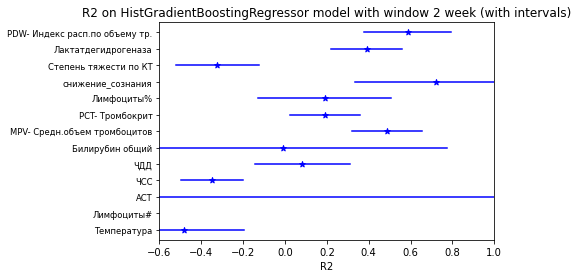

In [138]:
import numpy as np
def draw_stat_with_intervals(statistics_df, window=1, parameter="Fedot"):
    pldata = statistics_df[statistics_df["window"]==window][["right_r2", "left_r2", "mean_r2", "parameter", "model"]]
    psnames = [i[:len(i)-11] for i in pldata["parameter"]]
    for i in range(pldata.shape[0]):
        plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
        plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")
    plt.title(f"R2 on {parameter} model with window 2 week (with intervals)")
    plt.xlabel("R2")
    plt.yticks(range(len(psnames)), psnames , size='small')
    plt.xlim((-0.6, 1))
    plt.show()

linear_regression_stat_df = pd.read_csv("HistGradientBoostingRegressor_on_flat_vector.csv")
draw_stat_with_intervals(linear_regression_stat_df, 4, "HistGradientBoostingRegressor")


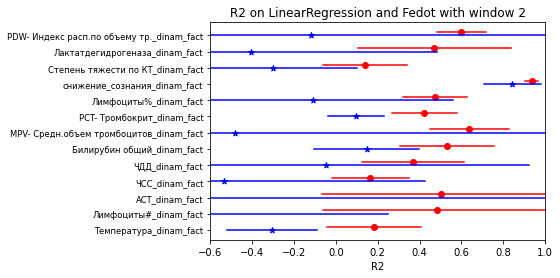

In [140]:

def draw_stat_with_intervals_compare(statistics_df_A, statistics_df_B, window=2, title="R2 on LinearRegression and Fedot with window 2"):
    pldata = statistics_df_A[["right_r2", "left_r2", "mean_r2", "parameter", "model"]]
    psnames = pldata["parameter"]
    for i in range(pldata.shape[0]):
        plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
        plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")
    pldata = statistics_df_B[["right_r2", "left_r2", "mean_r2", "parameter", "model"]]
    for i in range(pldata.shape[0]):
        plt.plot(pldata.iloc[i, 0:2], [i+0.2, i+0.2], c="red")
        plt.scatter(pldata.iloc[i, 2], [i+0.2], c="red", marker="o")
    plt.title(title)
    plt.xlabel("R2")
    plt.yticks(range(len(psnames)), psnames , size='small')
    plt.xlim((-0.6, 1))


linear_regression_stat_df = pd.read_csv("D:\covid\covid\LSTM.csv")
grad_regression_stat_df = pd.read_csv("D:\covid\covid\LinearRegression_on_flatten_vector.csv")
draw_stat_with_intervals_compare(grad_regression_stat_df[grad_regression_stat_df["window"]==3], linear_regression_stat_df[linear_regression_stat_df["window"]==1], "R2 on LinearRegression and Fedot with window 2")

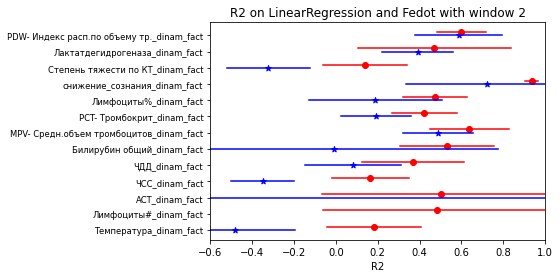

In [141]:
linear_regression_stat_df = pd.read_csv("D:\covid\covid\LSTM.csv")
grad_regression_stat_df = pd.read_csv("D:\covid\covid\HistGradientBoostingRegressor_on_flat_vector.csv")
draw_stat_with_intervals_compare(grad_regression_stat_df[grad_regression_stat_df["window"]==4], linear_regression_stat_df[linear_regression_stat_df["window"]==1], "R2 on HistGradientBoosting and Fedot with window 2")

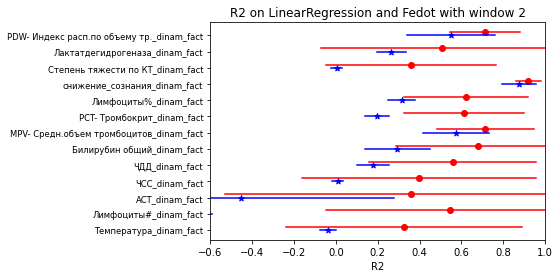

In [142]:
linear_regression_stat_df = pd.read_csv("D:\covid\covid\LSTM.csv")
grad_regression_stat_df = pd.read_csv("D:\covid\covid\Fedot_on_flat_vector.csv")
draw_stat_with_intervals_compare(grad_regression_stat_df[grad_regression_stat_df["window"]==3], linear_regression_stat_df[linear_regression_stat_df["window"]==2])

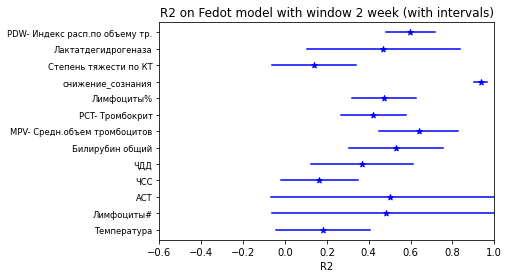

In [139]:
linear_regression_stat_df = pd.read_csv("D:\covid\covid\LSTM.csv")
grad_regression_stat_df = pd.read_csv("D:\covid\covid\Fedot_on_flat_vector.csv")
draw_stat_with_intervals(linear_regression_stat_df, 1)